# Erstellung eines ARIMA-Modells
1. [Dickey-Fuller-Test](#1)
1. [Train-Test-Split und Imputation](#2)
1. [AutoARIMA-Modell](#3)
1. [Exponential Smoothing](#4)
1. [Grafische Darstellung](#5)

In [1]:
!pip install darts

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/89/29/d5d086caa378240deb5d5e90982c772a8c4367e8688fb80754598ee35d14/darts-0.27.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.3 MB/s eta 0:00:00
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/ea/19/670e5cd11489f13befad8a0c15ddc646b706da2a114719e7d3b718fc325b/statsforecast-1.7.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
  Obtaining dependency information

In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from darts import TimeSeries
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [3]:
def print_metrics(actual, predicted):
    """
    Berechnet MAE, RMSE und MAPE zwischen den tatsächlichen und vorhergesagten Werten.
    :param actual: Array der tatsächlichen Werte.
    :param predicted: Array der vorhergesagten Werte.
    """
    actual, predicted = np.array(actual), np.array(predicted)

    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100

    print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}, MAPE: {round(mape, 2)} %")

In [4]:
df = pd.read_csv("../input/ps-ds2/ps_ds2.csv")
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df_save = df.copy()
df = df[['use']]

df.head()

,use
timestamp,
2018-01-01 00:00:00,0.58575
2018-01-01 01:00:00,0.43750
2018-01-01 02:00:00,0.47875
2018-01-01 03:00:00,0.52275
2018-01-01 04:00:00,0.41825


<a id="1"></a>
## 1. Dickey-Fuller-Test
* https://www.kaggle.com/code/kanncaa1/time-series-prediction-tutorial-with-eda
* https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
* https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results

In [5]:
result = adfuller(df.dropna())

test_statistic = result[0]
crit_values = result[4]
max_crit_value = max(crit_values.values())

print("Teststatistik: ", test_statistic)
print("Kritische Werte: ", crit_values)
print()

if test_statistic > max_crit_value: # Trend
    print(f"Die Teststatisik ist größer als die kritischen Werte bei 10%: {round(test_statistic, 2)} > {round(max_crit_value, 2)}")
    print("Die Nullhypothese kann nicht abgelehnt werden")
    print("Die Zeitreihe ist nicht stationär")
else: # Kein Trend
    print("Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt")
    print("Die Zeitreihe ist stationär")

Teststatistik:  -5.878320522991495
Kritische Werte:  {'1%': -3.4311082296069313, '5%': -2.8618750865101124, '10%': -2.566948361609558}

Die Teststatistik ist kleiner als die kritischen Werte bei 1%, daher können wir mit 99%iger Sicherheit sagen, dass es sich um eine stationäre Zeitreihe handelt
Die Zeitreihe ist stationär


<a id="2"></a>
## 2. Train-Test-Split und Imputation

In [6]:
train, test = train_test_split(df, train_size=0.8, shuffle=False)

# Imputation
simple_imputer = SimpleImputer(strategy='median')
train_data = pd.DataFrame(simple_imputer.fit_transform(train), index=train.index, columns=train.columns)
test_data = pd.DataFrame(simple_imputer.transform(test), index=test.index, columns=test.columns)

# Zu Darts Serie casten
train_series = TimeSeries.from_series(train_data)

<a id="3"></a>
## 3. AutoARIMA-Modell
### Setting m: https://alkaline-ml.com/pmdarima/tips_and_tricks.html#setting-m
Blog post: https://robjhyndman.com/hyndsight/seasonal-periods/
1. Saisonalitätsannahme: Der Wert m gibt die Länge der saisonalen Periode an. Bei m=24 geht das Modell davon aus, dass sich das Muster Ihrer Zeitreihe alle 24 Stunden wiederholt. Dies ist typisch für stündliche Daten, bei denen Sie tägliche Muster erwarten, wie z.B. höhere Aktivität während des Tages und niedrigere Aktivität in der Nacht.
2. Saisonale Differenzierung: Im Kontext von ARIMA-Modellen (und deren Erweiterungen wie SARIMA oder AutoARIMA) bezieht sich die saisonale Differenzierung auf die Anzahl der Differenzierungen, die erforderlich sind, um die saisonale Komponente der Zeitreihe stationär zu machen. Bei m=24 wird AutoARIMA versuchen, saisonale Effekte zu erkennen und zu modellieren, die sich im 24-Stunden-Rhythmus wiederholen.
3. Anwendungsbereiche: Ein solches Modell wäre beispielsweise sinnvoll bei der Analyse von Verkehrsdaten, Energieverbrauch, Webseitenaufrufen oder anderen stündlichen Messungen, bei denen tägliche Schwankungen eine Rolle spielen.
4. Modellierungskomplexität: Die Einbeziehung einer täglichen Saisonalität (m=24) in stündlichen Daten kann die Komplexität des Modells erhöhen. Es ist wichtig, die Modellpassung und -vorhersagen sorgfältig zu überprüfen, um sicherzustellen, dass das Modell die saisonalen Muster angemessen erfasst und nicht über- oder unterangepasst ist.

In [7]:
from darts.models import AutoARIMA

auto_arima_model = AutoARIMA(stationary=True, trend=None, seasonal=True,
                             trace=True, start_p=2, max_p=3, start_q=2, max_q=2)

auto_arima_model.fit(train_series)

auto_arima_predictions = auto_arima_model.predict(len(test_data))
print_metrics(test_data, auto_arima_predictions.values())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=17470.829, Time=9.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=22916.473, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=17677.973, Time=0.49 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=19159.155, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29314.660, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=17607.327, Time=4.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=17612.362, Time=3.69 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=17598.672, Time=5.72 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=17616.493, Time=1.18 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=17597.441, Time=4.61 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=17417.642, Time=4.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18088.133, Time=2.37 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18300.689, Time=1.28 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=4.51 sec
 ARIMA(1,0,1)(0,0,0)[0]  

In [8]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_data, order=(2,0,2))
model_fit = arima_model.fit()

all_data = pd.concat([train_data, test_data])
arima_predictions = model_fit.predict(start=all_data.index[0], end=all_data.index[-1])
print_metrics(all_data, arima_predictions)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


MAE: 0.61, RMSE: 0.89, MAPE: 749067231036646.2 %


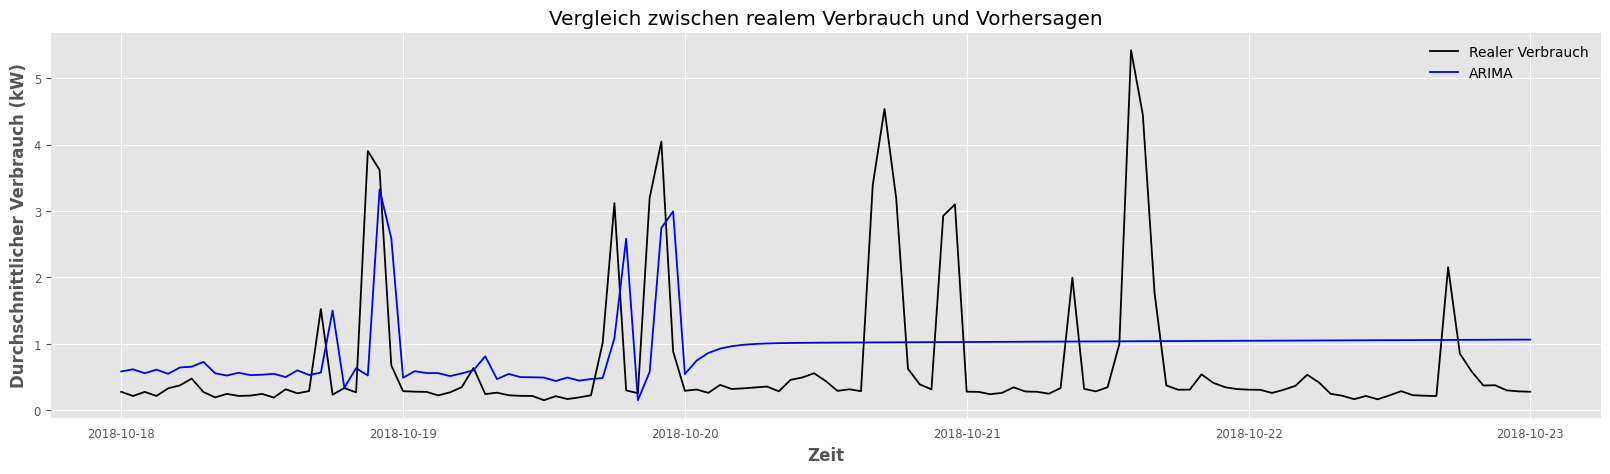

In [9]:
df_comp = pd.DataFrame(all_data)
df_comp.rename(columns={'use': 'actual'}, inplace=True)
df_comp['arima_preds'] = arima_predictions

start_idx = pd.to_datetime('2018-10-18')
end_idx = pd.to_datetime('2018-10-23')
df_plot = df_comp[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_plot.index, df_plot.actual, color='black', label='Realer Verbrauch')
plt.plot(df_plot.index, df_plot.arima_preds, color='blue', label='ARIMA')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.legend()
plt.show()

# Wie kann ich das als Feature für die ML-Modelle verwenden?
# Overfitting?

<a id="4"></a>
## 4. Exponential Smoothing

In [10]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing(trend=None, seasonal_periods=24)
es_model.fit(train_series)

es_predictions = es_model.predict(len(test_data))
print_metrics(test_data, es_predictions.values())

MAE: 0.73, RMSE: 0.97, MAPE: 128.17 %


<a id="5"></a>
## 5. Grafische Darstellung

In [11]:
df_comp_test = pd.DataFrame(test_data)
df_comp_test.rename(columns={'use': 'actual'}, inplace=True)
df_comp_test['auto_arima_preds'] = auto_arima_predictions.values()
df_comp_test['es_preds'] = es_predictions.values()
df_comp_test.head()

,actual,auto_arima_preds,es_preds
timestamp,,,
2018-10-20 00:00:00,0.29500,0.532295,1.045010
2018-10-20 01:00:00,0.31450,0.722154,0.831119
2018-10-20 02:00:00,0.26425,0.829458,0.707052
2018-10-20 03:00:00,0.38375,0.890063,0.641566
2018-10-20 04:00:00,0.32200,0.924254,0.584934


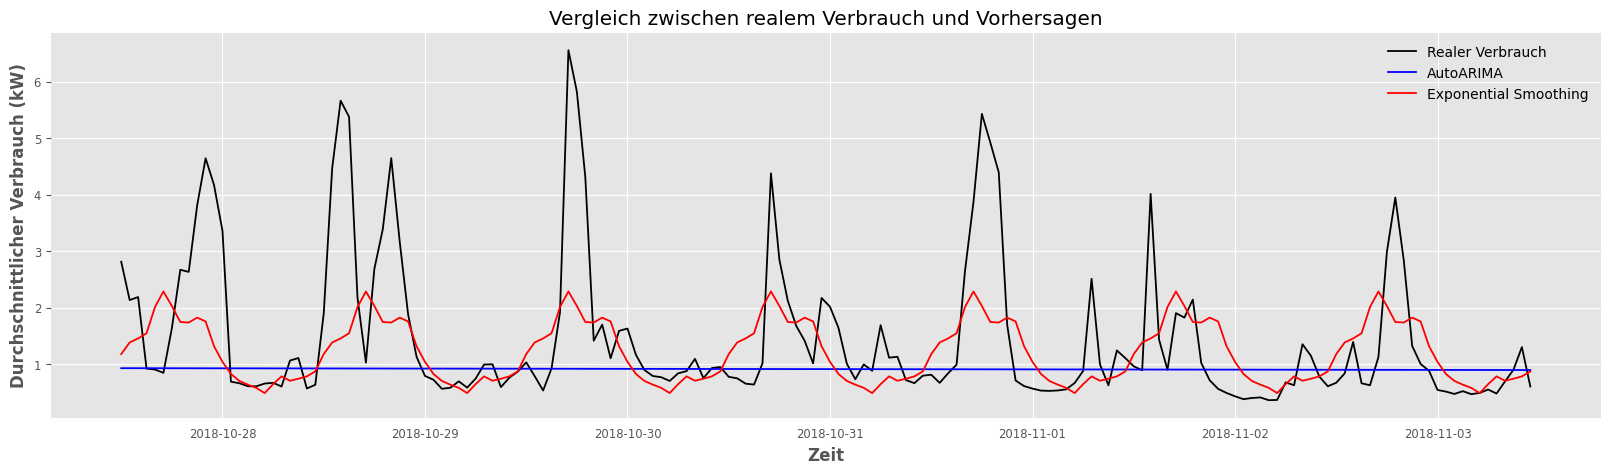

In [12]:
datapoints_per_week = 24 * 7
last_start_idx = len(df_comp_test) - 1 - datapoints_per_week
start_idx = random.randint(0, last_start_idx)
end_idx = start_idx + datapoints_per_week
df_plot_test = df_comp_test[start_idx:end_idx]

plt.figure(figsize=(20, 5))
plt.plot(df_plot_test.index, df_plot_test.actual, color='black', label='Realer Verbrauch')
plt.plot(df_plot_test.index, df_plot_test.auto_arima_preds, color='blue', label='AutoARIMA')
plt.plot(df_plot_test.index, df_plot_test.es_preds, color='red', label='Exponential Smoothing')
plt.title('Vergleich zwischen realem Verbrauch und Vorhersagen')
plt.xlabel('Zeit')
plt.ylabel('Durchschnittlicher Verbrauch (kW)')
plt.legend()
plt.show()

In [13]:
# Als csv-Datei speichern
df_save['arima_preds'] = df_comp.arima_preds
df_save.to_csv('ps_ds3.csv')